In [1]:

%pprint
import sys
sys.path.insert(1, '../py')

Pretty printing has been turned OFF


In [2]:

from datetime import timedelta
from frvrs_utils import FRVRSUtilities
from notebook_utils import NotebookUtilities
import humanize
import matplotlib.pyplot as plt
import os
import os.path as osp
import re

nu = NotebookUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
fu = FRVRSUtilities(
    data_folder_path=osp.abspath('../data'),
    saves_folder_path=osp.abspath('../saves')
)
PNG_PATH = '../saves/png'
os.makedirs(name=PNG_PATH, exist_ok=True)


# Visualize every DM/Patient Interaction

In [3]:

# Get all CSVs out of one data frame
if nu.pickle_exists('frvrs_logs_df'):
    frvrs_logs_df = nu.load_object('frvrs_logs_df')
    print(frvrs_logs_df.shape)
    # df = frvrs_logs_df.sample(4).dropna(axis='columns', how='all')
    # display(df.T)

(829277, 114)



## Visualize the order of patient engagement on one scene's timeline

In [5]:

# Group each patient, run, and session with non-null patient IDs
start_stop_list = ['SESSION_END', 'SESSION_START']
patient_mask_series = frvrs_logs_df.action_type.isin(fu.responder_negotiations_list + start_stop_list)
scene_gb = frvrs_logs_df[patient_mask_series].sort_values(['action_tick']).groupby(fu.scene_groupby_columns)

# Loop through each unique file/scene/patient combination
time_groups_dict = {}
consecutive_time_groups_dict = {}
for (session_uuid, scene_id), scene_df in scene_gb:
    key = (session_uuid, scene_id)
    actions_list = []
    patient_ids_set = set()
    for row_index, row_series in scene_df.iterrows():
        patient_id = row_series.patient_id
        action_type = row_series.action_type
        if action_type in start_stop_list: actions_list.append(action_type)
        else:
            actions_list.append(patient_id)
            patient_ids_set.add(patient_id)
    time_groups_dict[key] = actions_list
    for patient_id in patient_ids_set: actions_list = fu.replace_consecutive_elements(actions_list, element=patient_id)
    consecutive_time_groups_dict[key] = actions_list

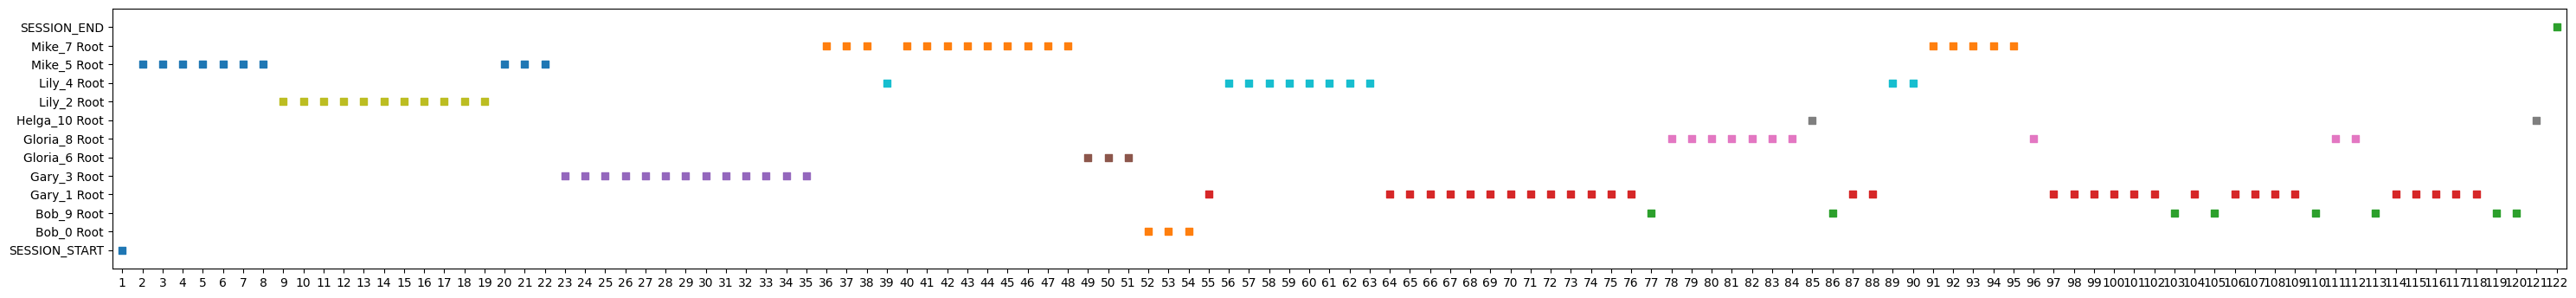

In [5]:

# Plot the time groups sequence with the fewest number of patients
scene_tuple, sequence = sorted([(k, v) for k, v in time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[14]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
mask_series = ~scene_df.patient_sort.isnull()
sort_to_color_dict = {'still': 'black', 'waver': 'red', 'walker': 'green'}
for patient_id, patient_df in scene_df[mask_series].groupby('patient_id'):
    patient_color_dict[patient_id] = sort_to_color_dict.get(patient_df.patient_sort.max(), 'grey')
if(sequence): plt = nu.plot_sequence(sequence, color_dict=None);

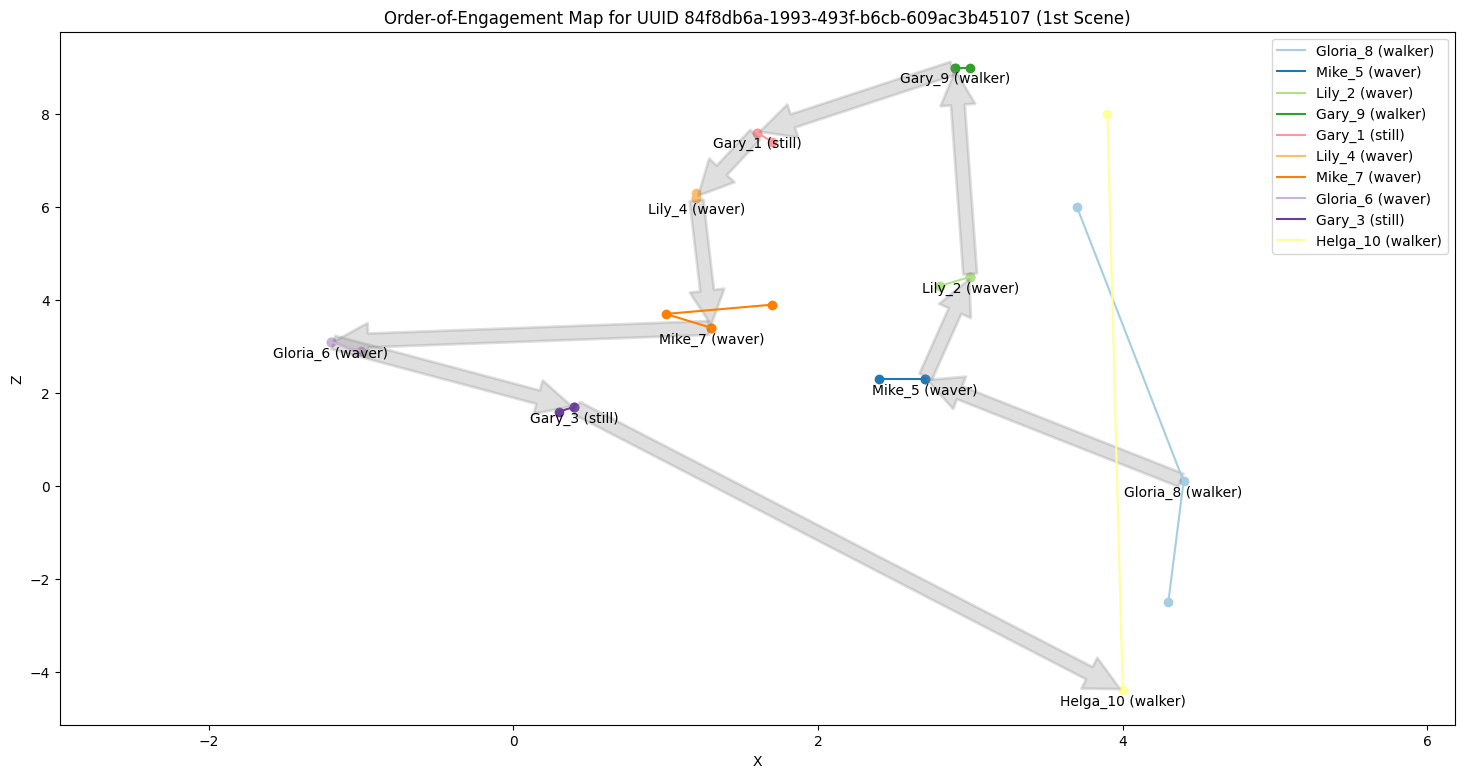

In [21]:

# Plot the worst order of engagement
keys_list = list(frvrs_logs_df.groupby(fu.scene_groupby_columns).filter(lambda x: x.patient_id.nunique() == 11).groupby(fu.scene_groupby_columns).groups.keys())
engagement_sort_df = nu.load_object('engagement_sort_df')
f = lambda srs: (srs.session_uuid, srs.scene_id) in keys_list
mask_series = engagement_sort_df.apply(f, axis='columns')
min_rsquared_adj = engagement_sort_df[mask_series].rsquared_adj.min()
mask_series = (engagement_sort_df.rsquared_adj == min_rsquared_adj)
keys_list = list(engagement_sort_df[mask_series].groupby(fu.scene_groupby_columns).groups.keys())
scene_tuple, sequence = sorted([(k, v) for k, v in consecutive_time_groups_dict.items() if k in keys_list], key=lambda x: len(x[1]), reverse=True)[0]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)

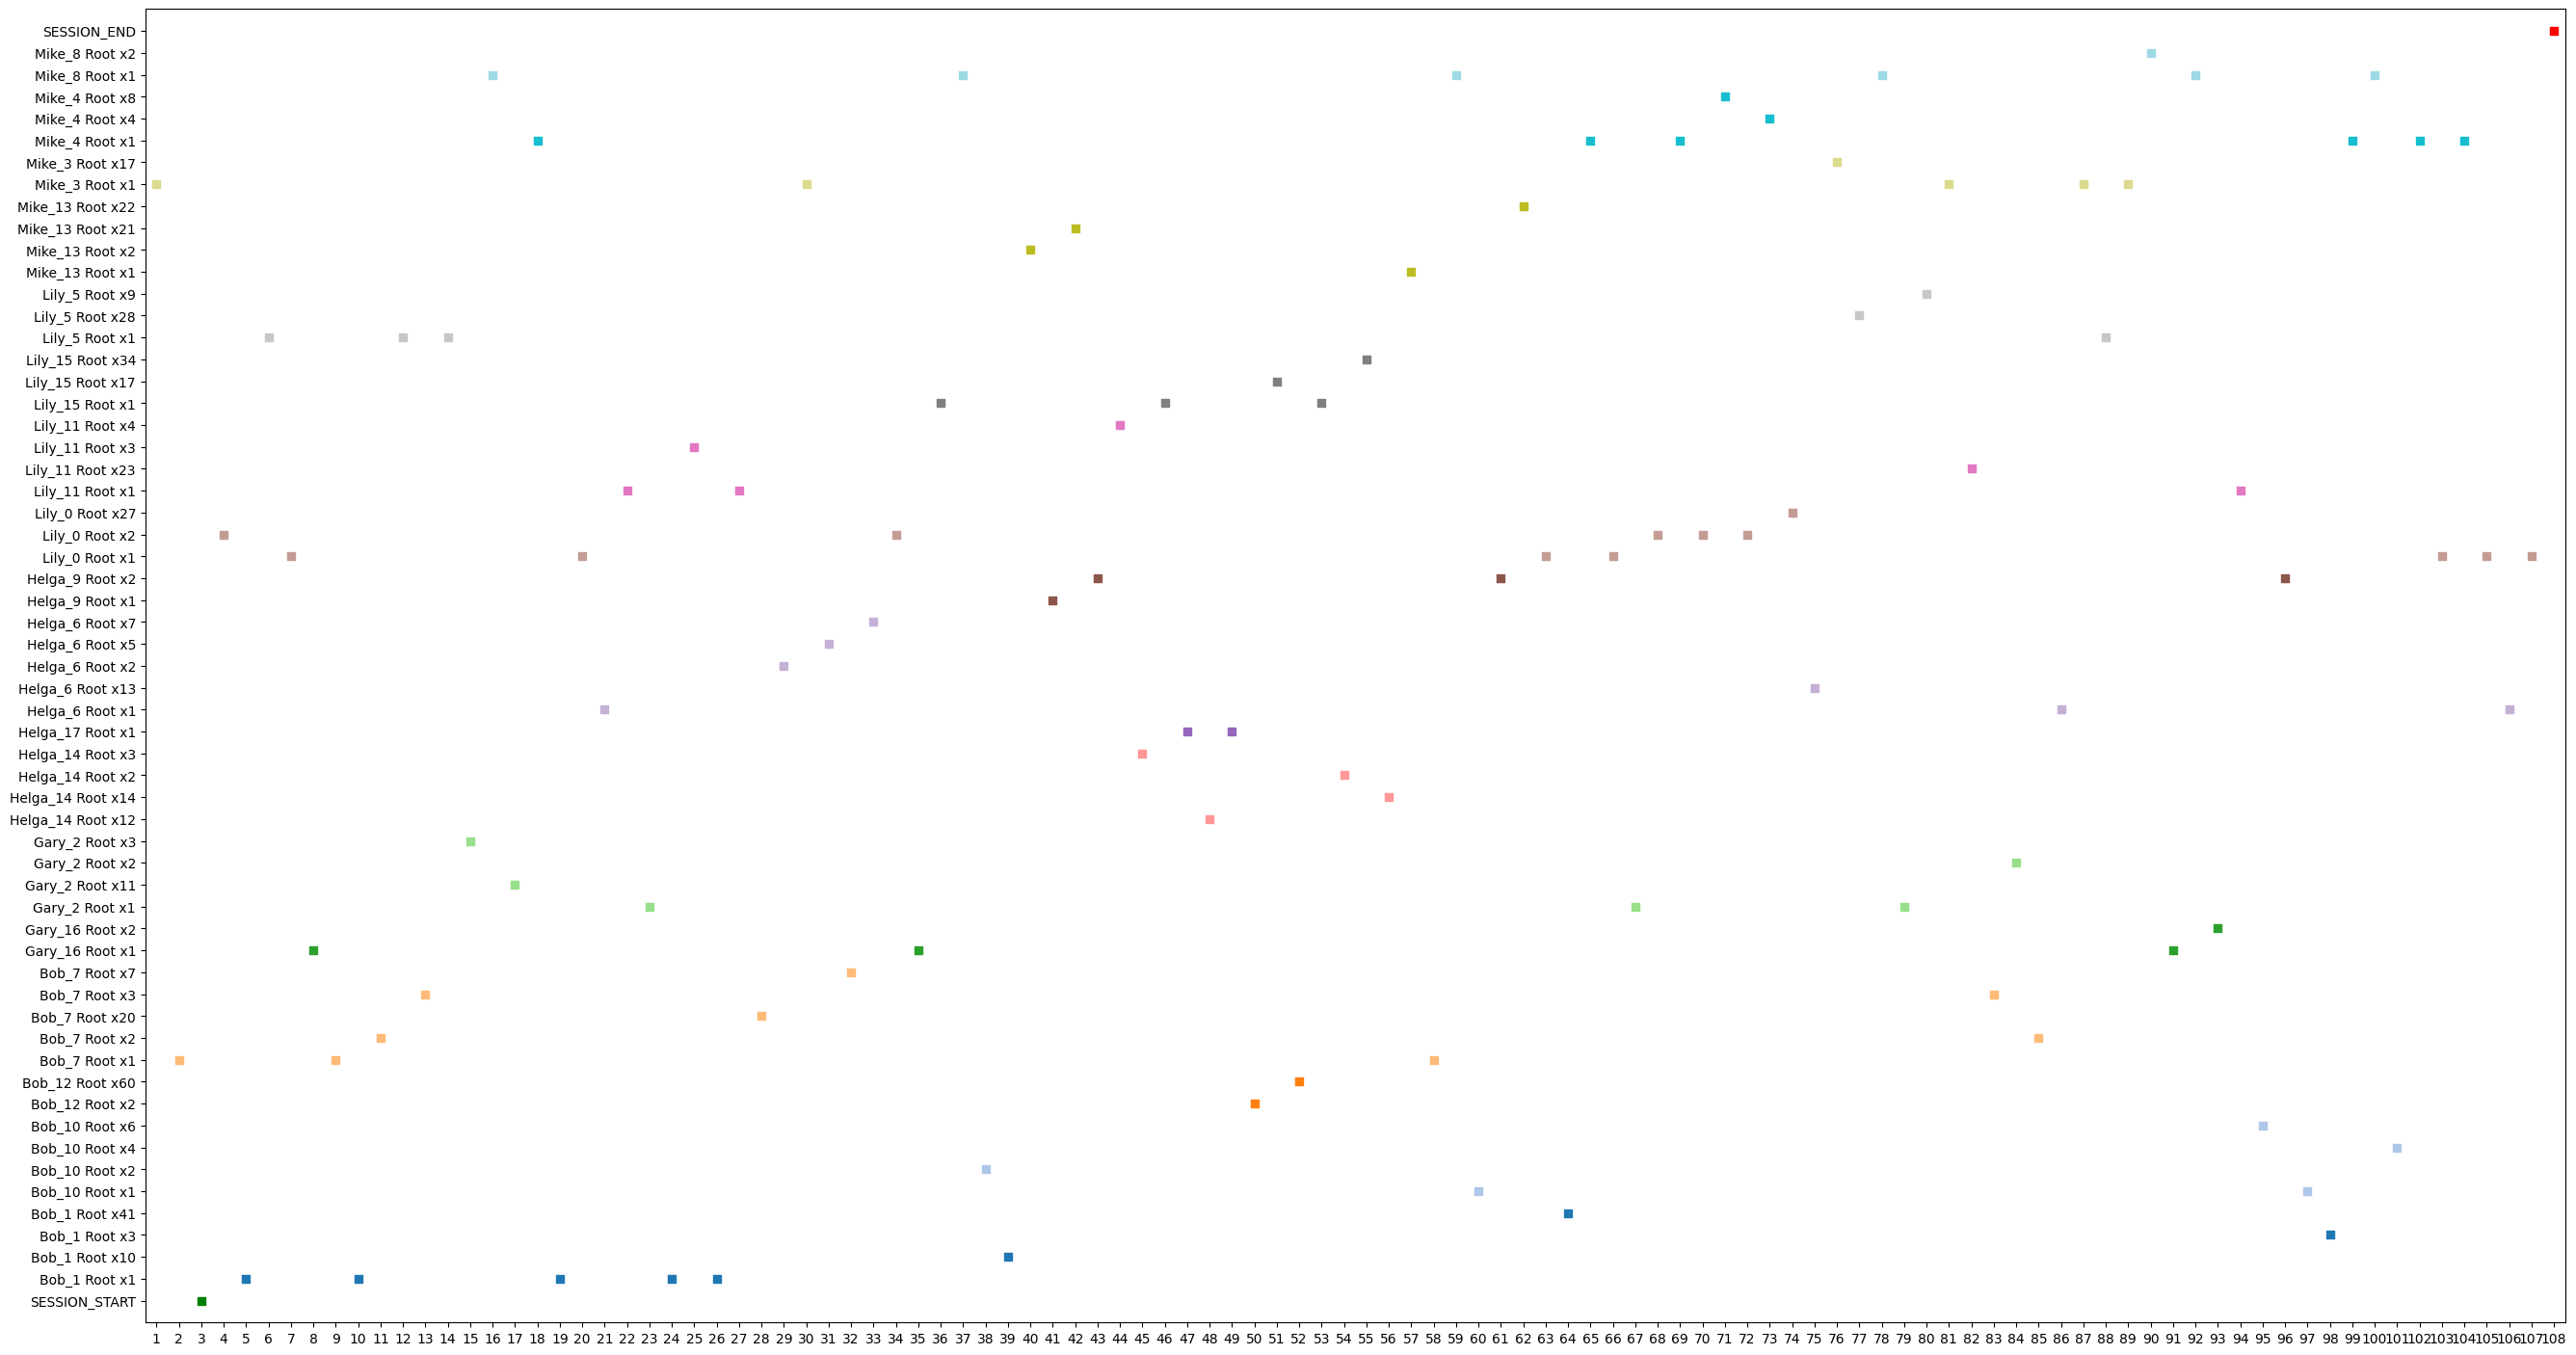

In [6]:

# Plot the consecutive time groups sequence with the fewest number of groupings
import matplotlib.colors as mcolors

scene_tuple, sequence = sorted([(k, v) for k, v in consecutive_time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[0]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

# Get a color for each patient
patient_color_dict = {'SESSION_START': 'green', 'SESSION_END': 'red'}
color_cycler = nu.get_color_cycler(fu.get_patient_count(scene_df))
for patient_id, face_color_dict in zip(scene_df.groupby('patient_id').groups.keys(), color_cycler()):
    rgba = face_color_dict['color']
    hex_color = mcolors.to_hex(rgba)
    patient_color_dict[patient_id] = hex_color

if(sequence):    
    consec_regex = re.compile(r' x\d+$')
    for xel in sequence:
        if xel not in patient_color_dict.keys():
            el = consec_regex.sub('', xel)
            if el in patient_color_dict: patient_color_dict[xel] = patient_color_dict[el]

plt = nu.plot_sequence(sequence, color_dict=patient_color_dict);

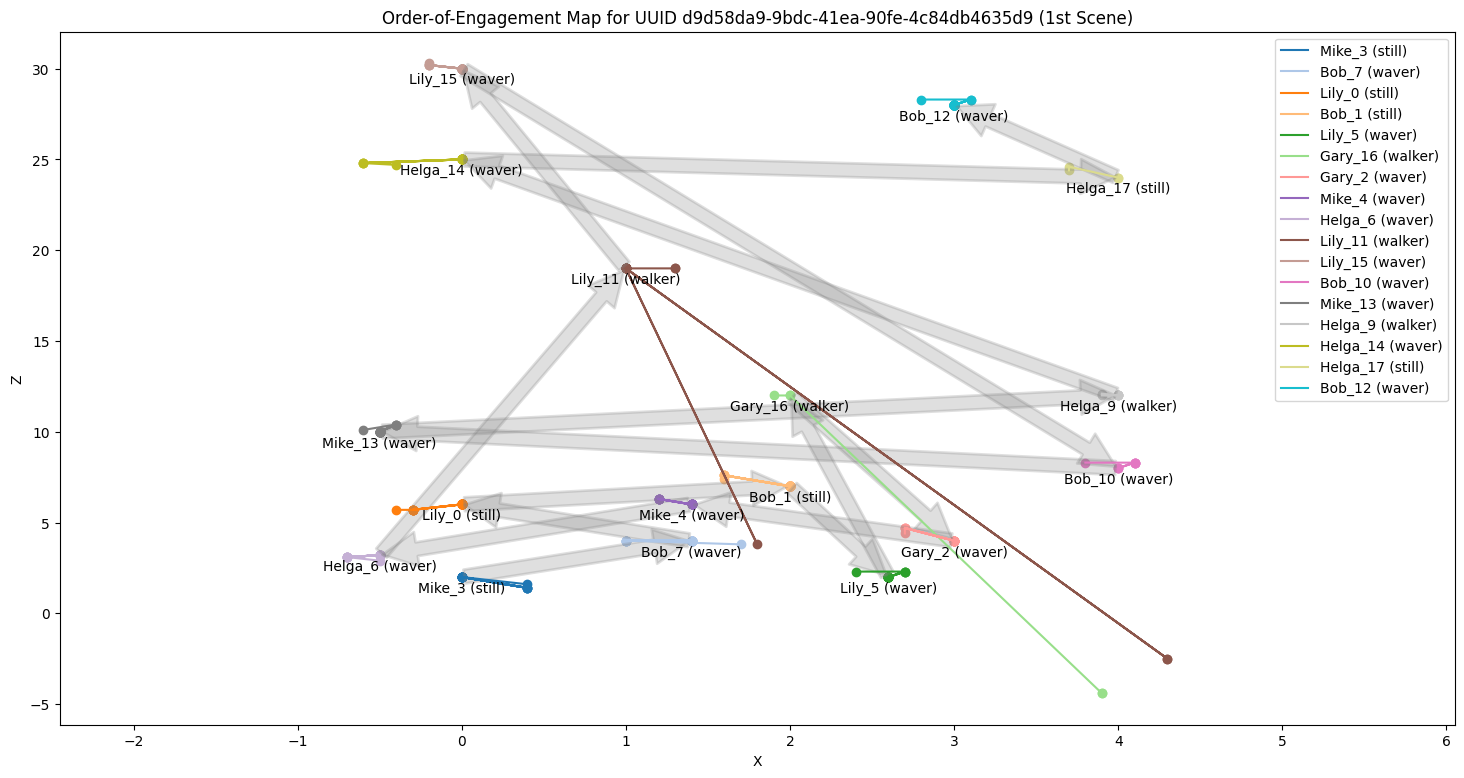

In [7]:

%matplotlib inline
import matplotlib.pyplot as plt

# Get the entire hisotry of the best scene
scene_tuple, sequence = sorted([(k, v) for k, v in consecutive_time_groups_dict.items()], key=lambda x: len(x[1]), reverse=True)[0]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)

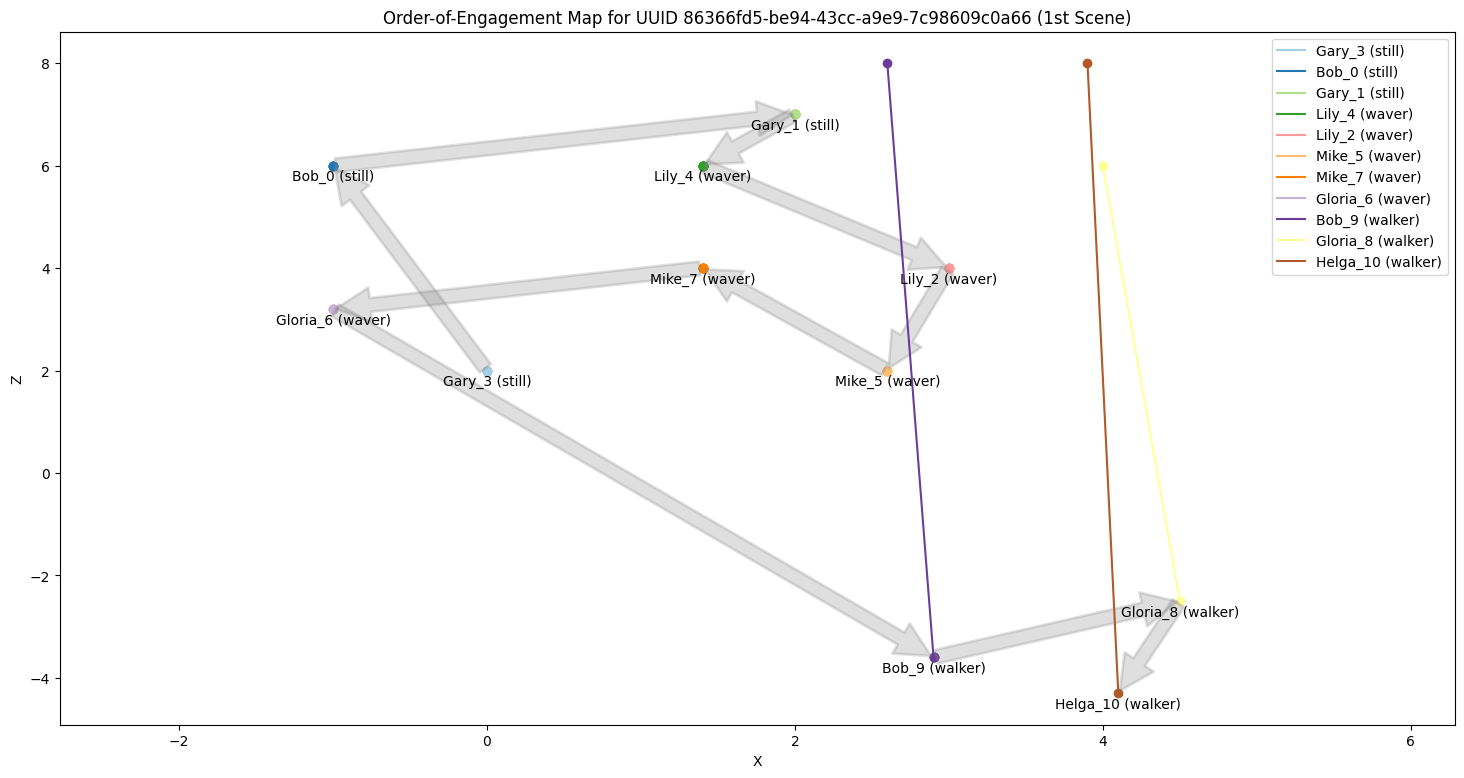

In [8]:

engagement_sort_df = nu.load_object('engagement_sort_df')
mask_series = (engagement_sort_df.rsquared_adj == 1.0)
keys_list = list(engagement_sort_df[mask_series].groupby(['session_uuid', 'scene_id']).groups.keys())
scene_tuple, sequence = sorted([(k, v) for k, v in consecutive_time_groups_dict.items() if k in keys_list], key=lambda x: len(x[1]), reverse=True)[0]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)

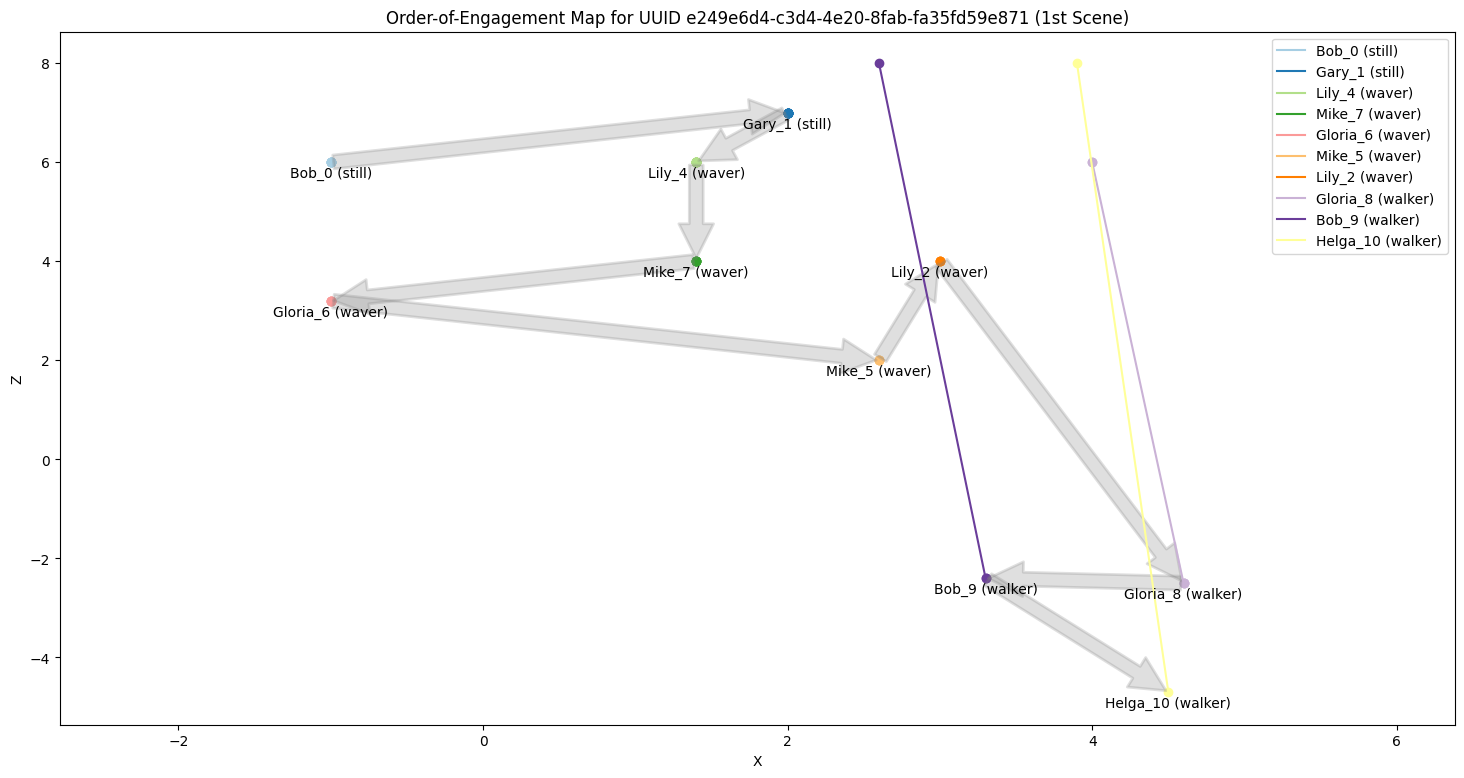

In [9]:

scene_tuple, _ = sorted([(k, v) for k, v in consecutive_time_groups_dict.items() if k in keys_list], key=lambda x: len(x[1]), reverse=True)[1]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)

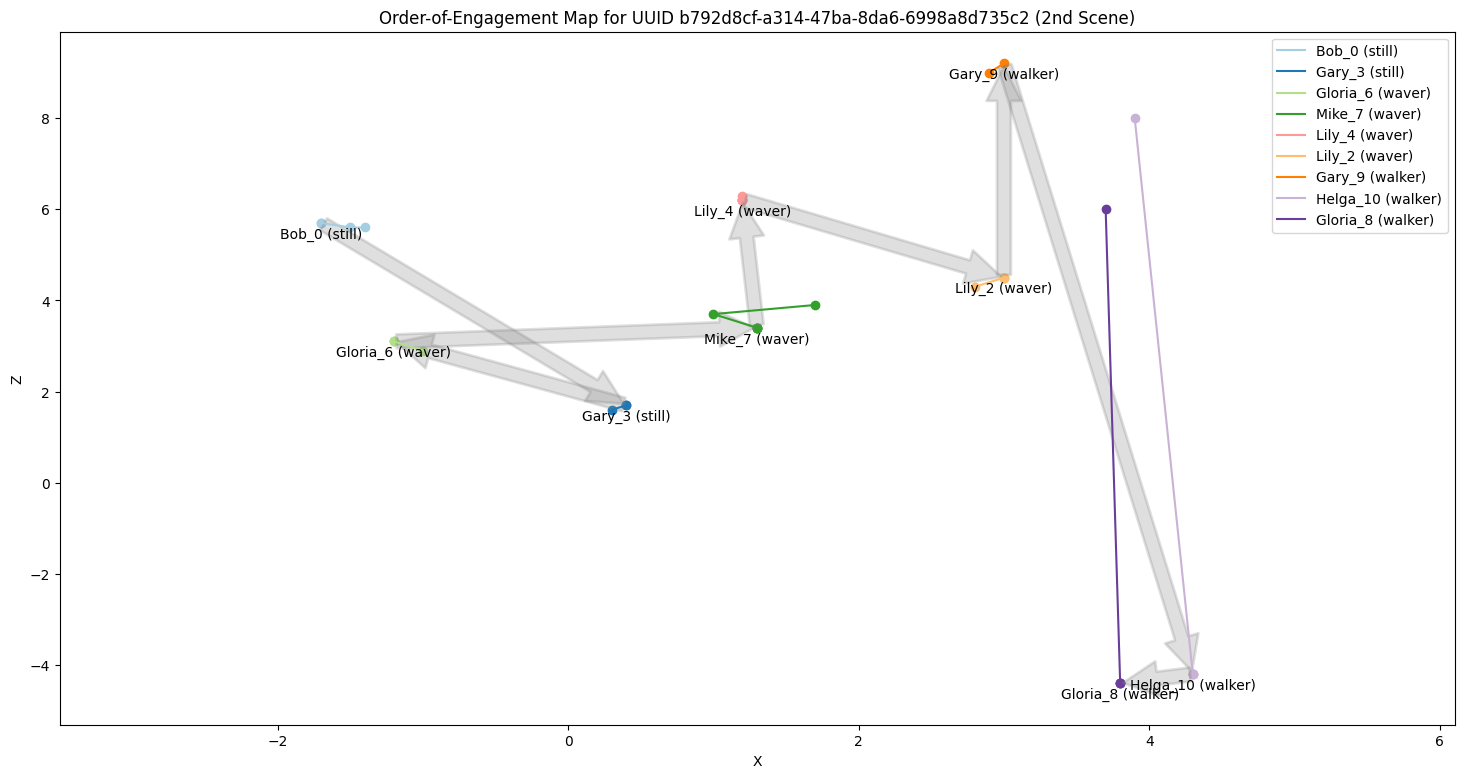

In [10]:

scene_tuple, _ = sorted([(k, v) for k, v in consecutive_time_groups_dict.items() if k in keys_list], key=lambda x: len(x[1]), reverse=True)[2]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)

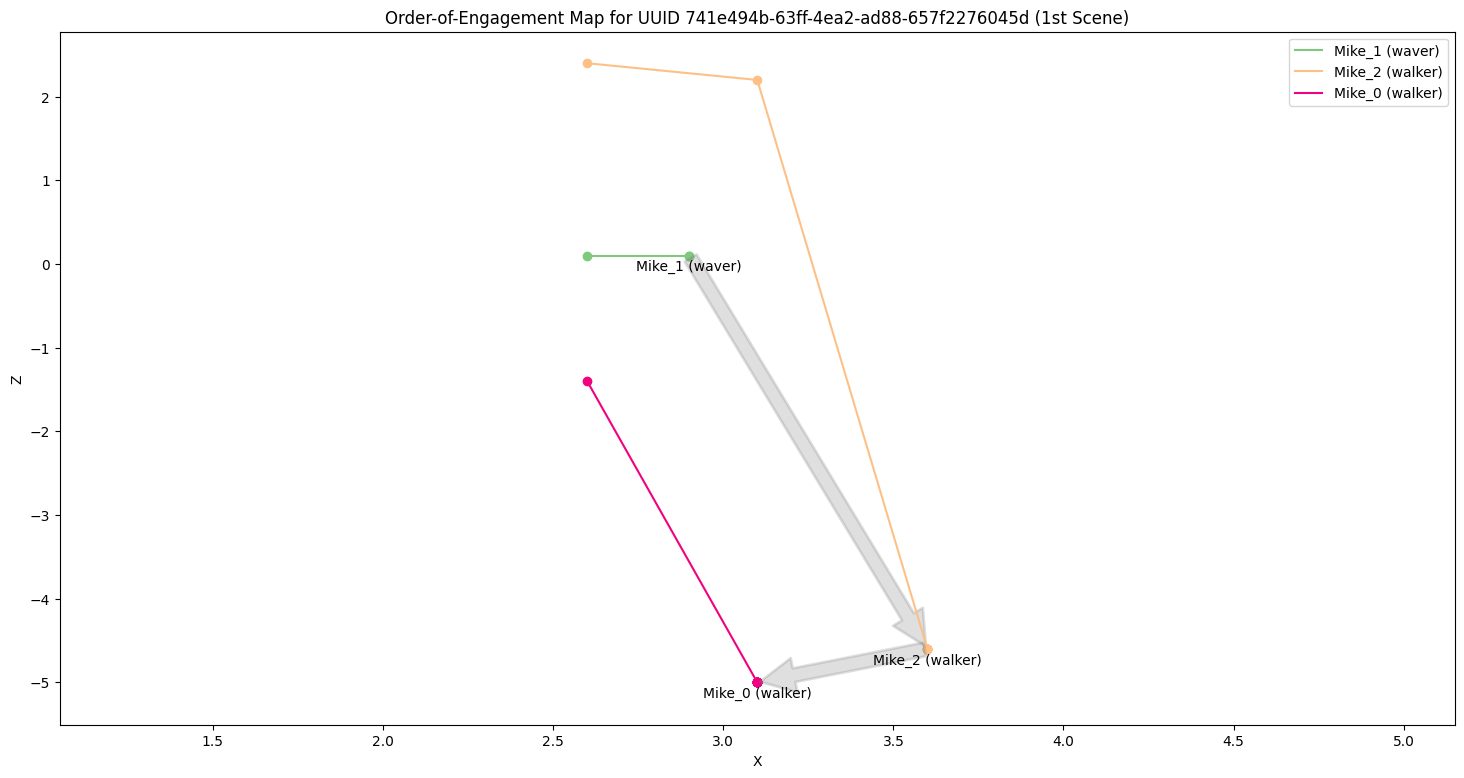

In [11]:

scene_tuple, _ = sorted([(k, v) for k, v in consecutive_time_groups_dict.items() if k in keys_list], key=lambda x: len(x[1]), reverse=True)[3]
mask_series = (frvrs_logs_df.session_uuid == scene_tuple[0]) & (frvrs_logs_df.scene_id == scene_tuple[1])
scene_df = frvrs_logs_df[mask_series]

fu.visualize_order_of_engagement(scene_df, nu=nu)


## Visualize the decision points on one patient's timeline

In [4]:

def show_timeline(random_session_uuid=None, random_time_group=None, random_patient_id=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(self.frvrs_logs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (self.frvrs_logs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(self.frvrs_logs_df[mask_series].scene_id.unique())
    
    # Get the scene mask
    scene_mask_series = (self.frvrs_logs_df.session_uuid == random_session_uuid) & (self.frvrs_logs_df.scene_id == random_time_group)
    
    # Get a random patient from within the scene
    if random_patient_id is None:
        random_patient_id = random.choice(self.frvrs_logs_df[scene_mask_series].patient_id.unique())
    
    # Get the event time and elapsed time of the person engaged
    mask_series = scene_mask_series & (self.frvrs_logs_df.patient_id == random_patient_id)
    mask_series &= self.frvrs_logs_df.action_type.isin([
        'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
    ])
    columns_list = ['action_tick']
    patient_engagements_df = self.frvrs_logs_df[mask_series][columns_list].sort_values(['action_tick'])
    if verbose: display(patient_engagements_df)
    if patient_engagements_df.shape[0]:
        
        # For the patient, get a timeline of every reference on or before engagement
        hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
        hlineaction_types_list = []; vlinexs_list = []
        left_lim = 999999; right_lim = -999999
        if True:
            
            # Get the broad horizontal line parameters
            hlineys_list.append(0)
            hlinecolors_list.append(plt.cm.Accent(0))
            hlinelabels_list.append(random_patient_id)
            
            # Create the filter for the first scene
            mask_series = scene_mask_series & (self.frvrs_logs_df.patient_id == random_patient_id)
            action_tick = patient_engagements_df.action_tick.max()
            mask_series &= (self.frvrs_logs_df.action_tick <= action_tick)
            
            df1 = self.frvrs_logs_df[mask_series].sort_values(['action_tick'])
            if verbose: display(df1)
            if df1.shape[0]:
                
                # Get the fine horizontal line parameters and plot dimensions
                xmin = df1.action_tick.min(); hlinexmins_list.append(xmin);
                if xmin < left_lim: left_lim = xmin
                xmax = df1.action_tick.max(); hlinexmaxs_list.append(xmax);
                if xmax > right_lim: right_lim = xmax
                
                # Get the vertical line parameters
                mask_series = df1.action_type.isin(['SESSION_END', 'SESSION_START'])
                for x in df1[mask_series].action_tick:
                    vlinexs_list.append(x)
                
                # Get the action type annotation parameters
                y = 0
                mask_series = df1.action_type.isin(['INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'])
                for label, action_type_df in df1[mask_series].groupby('action_type'):
                    for x in action_type_df.action_tick:
                        annotation_tuple = (label.lower().replace('_', ' '), x, y)
                        hlineaction_types_list.append(annotation_tuple)
    
    ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
    
    # Add the timelines to the figure subplot axis
    if verbose: print(hlineys_list, hlinexmins_list, hlinexmaxs_list, hlinecolors_list)
    line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
    
    # Label each timeline with the appropriate patient name
    for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
        plt.annotate(label.replace(' Root', ''), (x, y), textcoords='offset points', xytext=(0, -8), ha='left')
    
    # Annotate the action types along their timeline
    for annotation_tuple in hlineaction_types_list:
        label, x, y = annotation_tuple
        plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 0), va='center', rotation=90, fontsize=6)
    
    # Mark any session boundaries with a vertical line
    ymin, ymax = ax.get_ylim()
    line_collection_obj = ax.vlines(vlinexs_list, ymin=ymin, ymax=ymax)
    
    # Remove the ticks and tick labels from the y axis
    ax.set_yticks([])
    ax.set_yticklabels([])
    
    # Move the top and right border out so that the annotations don't cross it
    # plt.subplots_adjust(top=1.5)
    # xlim_tuple = ax.set_xlim(left_lim, right_lim+10_000)
    
    # Set the title and labels
    patient_name = random_patient_id.replace(' Root', '')
    ax.set_title(f'Patient {patient_name} Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
    ax.set_xlabel('Elapsed Time since Scene Start')
    
    # tick_labels = ax.get_xticklabels()
    # print(tick_labels)
    
    from matplotlib.text import Text
    ax.set_xticklabels([
        Text(300000.0, 0, humanize.precisedelta(timedelta(milliseconds=300000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(400000.0, 0, humanize.precisedelta(timedelta(milliseconds=400000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(500000.0, 0, humanize.precisedelta(timedelta(milliseconds=500000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(600000.0, 0, humanize.precisedelta(timedelta(milliseconds=600000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(700000.0, 0, humanize.precisedelta(timedelta(milliseconds=700000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(800000.0, 0, humanize.precisedelta(timedelta(milliseconds=800000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(900000.0, 0, humanize.precisedelta(timedelta(milliseconds=900000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(1000000.0, 0, humanize.precisedelta(timedelta(milliseconds=1000000.0)).replace(', ', ',\n').replace(' and ', ' and\n')),
        Text(1100000.0, 0, humanize.precisedelta(timedelta(milliseconds=1100000.0)).replace(', ', ',\n').replace(' and ', ' and\n'))
    ]);

    return random_session_uuid, random_time_group, random_patient_id

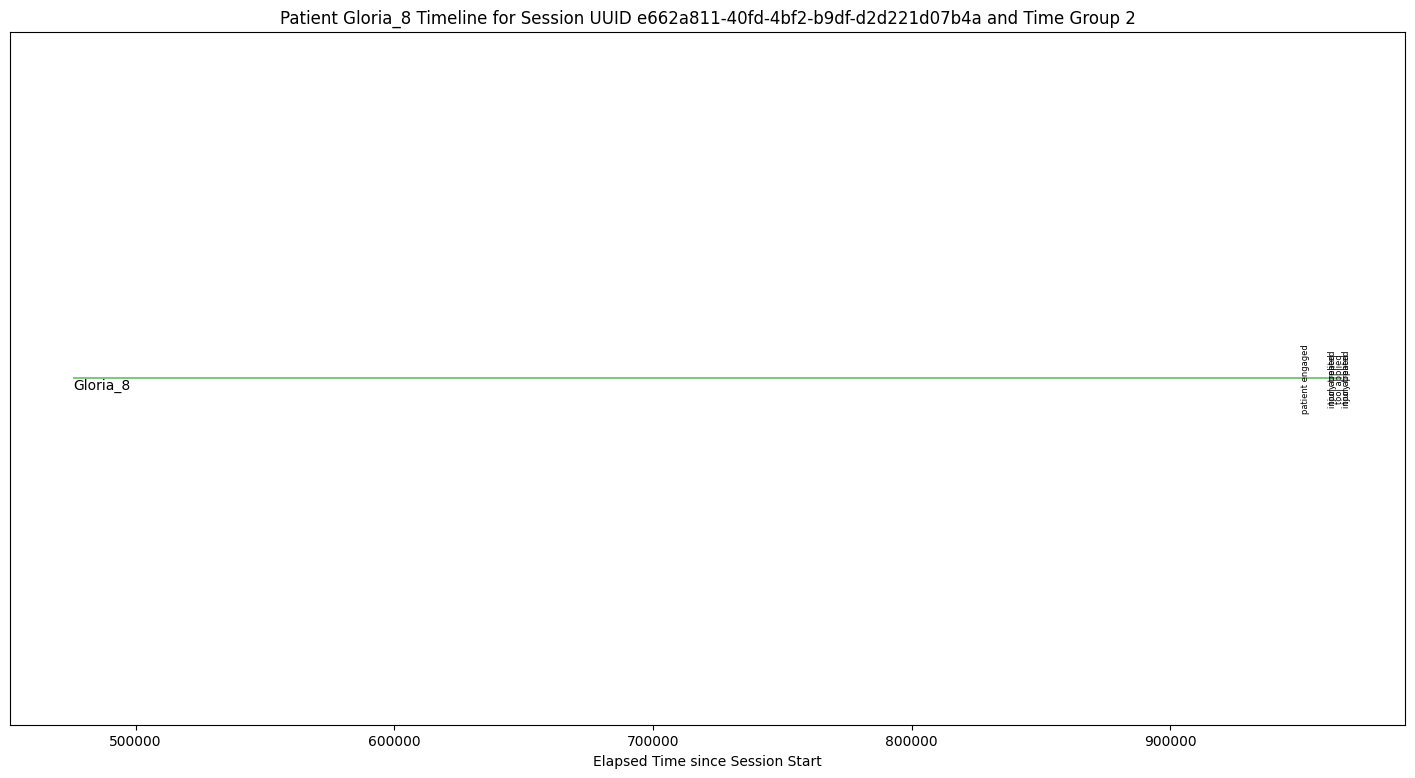

In [11]:

%matplotlib inline

random_session_uuid, random_time_group, random_patient_id = show_timeline('e662a811-40fd-4bf2-b9df-d2d221d07b4a', 2, 'Gloria_8 Root', verbose=False)

In [27]:

def store_timelines(random_session_uuid=None, random_time_group=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(frvrs_logs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (frvrs_logs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(frvrs_logs_df[mask_series].scene_id.unique())
    
    file_path = os.path.join(PNG_PATH, f'{random_session_uuid}_{random_time_group}.png')
    if not os.path.exists(file_path):
        
        # Get the event time and elapsed time of each person engaged
        base_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
        mask_series = base_mask_series & frvrs_logs_df.action_type.isin([
            'PATIENT_ENGAGED', 'INJURY_TREATED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'
        ])
        columns_list = ['patient_id', 'action_tick']
        patient_engagements_df = frvrs_logs_df[mask_series][columns_list].sort_values(['action_tick'])
        if verbose: display(patient_engagements_df)
        
        # For each patient, get a timeline of every reference on or before engagement
        color_cycler = nu.get_color_cycler(len(patient_engagements_df.patient_id.unique()))
        hlineys_list = []; hlinexmins_list = []; hlinexmaxs_list = []; hlinecolors_list = []; hlinelabels_list = []
        hlineaction_types_list = []; vlinexs_list = []
        left_lim = 999999; right_lim = -999999
        for (patient_id, patient_df), (y, face_color_dict) in zip(patient_engagements_df.groupby('patient_id'), enumerate(color_cycler())):
        
            # Get the broad horizontal line parameters
            hlineys_list.append(y)
            face_color = face_color_dict['color']
            hlinecolors_list.append(face_color)
            hlinelabels_list.append(patient_id)
        
            # Create the filter for the first scene
            mask_series = base_mask_series & (frvrs_logs_df.patient_id == patient_id)
            action_tick = patient_df.action_tick.max()
            mask_series &= (frvrs_logs_df.action_tick <= action_tick)
            
            df1 = frvrs_logs_df[mask_series].sort_values(['action_tick'])
        
            # Get the fine horizontal line parameters and plot dimensions
            xmin = df1.action_tick.min(); hlinexmins_list.append(xmin);
            if xmin < left_lim: left_lim = xmin
            xmax = df1.action_tick.max(); hlinexmaxs_list.append(xmax);
            if xmax > right_lim: right_lim = xmax
            
            # Get the vertical line parameters
            mask_series = df1.action_type.isin(['SESSION_END', 'SESSION_START'])
            for x in df1[mask_series].action_tick:
                vlinexs_list.append(x)
            
            # Get the action type annotation parameters
            mask_series = df1.action_type.isin(['INJURY_TREATED', 'PATIENT_ENGAGED', 'PULSE_TAKEN', 'TAG_APPLIED', 'TOOL_APPLIED'])
            for label, action_type_df in df1[mask_series].groupby('action_type'):
                for x in action_type_df.action_tick:
                    annotation_tuple = (label.lower().replace('_', ' '), x, y)
                    hlineaction_types_list.append(annotation_tuple)
        
        plt.ioff()
        ax = plt.figure(figsize=(18, 9)).add_subplot(1, 1, 1)
        
        # Add the timelines to the figure subplot axis
        line_collection_obj = ax.hlines(hlineys_list, hlinexmins_list, hlinexmaxs_list, colors=hlinecolors_list)
        
        # Label each timeline with the appropriate patient name
        for label, x, y in zip(hlinelabels_list, hlinexmins_list, hlineys_list):
            plt.annotate(label.replace(' Root', ''), (x, y), textcoords='offset points', xytext=(0, -8), ha='left')
        
        # Annotate the action types along their timeline
        for annotation_tuple in hlineaction_types_list:
            label, x, y = annotation_tuple
            plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, 0), va='center', rotation=90, fontsize=6)
        
        # Mark any session boundaries with a vertical line
        ymin, ymax = ax.get_ylim()
        line_collection_obj = ax.vlines(vlinexs_list, ymin=ymin, ymax=ymax)
        
        # Remove the ticks and tick labels from the y axis
        ax.set_yticks([])
        ax.set_yticklabels([])
        
        # Move the top and right border out so that the annotations don't cross it
        plt.subplots_adjust(top=1.5)
        xlim_tuple = ax.set_xlim(left_lim-10_000, right_lim+10_000)
        
        # Set the title and labels
        ax.set_title(f'Multi-Patient Timeline for UUID {random_session_uuid} and Scene {random_time_group}')
        ax.set_xlabel('Elapsed Time since Scene Start')
    
        # Save the figure to PNG
        plt.savefig(file_path, bbox_inches='tight')
        plt.ion()

In [28]:

for (session_uuid, scene_id), df in fu.get_session_groupby(mask_series=None, extra_column='scene_id'):
    store_timelines(random_session_uuid=session_uuid, random_time_group=scene_id, verbose=False)

In [22]:

def store_teleportations(random_session_uuid=None, random_time_group=None, verbose=False):
    
    # Get a random session
    if random_session_uuid is None:
        random_session_uuid = random.choice(frvrs_logs_df.session_uuid.unique())
    
    # Get a random scene from within the session
    if random_time_group is None:
        mask_series = (frvrs_logs_df.session_uuid == random_session_uuid)
        random_time_group = random.choice(frvrs_logs_df[mask_series].scene_id.unique())
    
    file_path = os.path.join(PNG_PATH, f'teleportations_{random_session_uuid}_{random_time_group}.png')
    if not os.path.exists(file_path):
        
        # Get the event time and elapsed time of each person engaged
        base_mask_series = (frvrs_logs_df.session_uuid == random_session_uuid) & (frvrs_logs_df.scene_id == random_time_group)
        plt.ioff()
        ax = plt.figure(figsize=(18, 9)).add_subplot()
        
        # Show the positions of patients recorded and engaged at our scene and session UUID
        color_cycler = nu.get_color_cycler(frvrs_logs_df[base_mask_series].groupby('patient_id').size().shape[0])
        location_cns_list = ['patient_record_position', 'patient_engaged_position']
        for ((session_uuid, patient_id), patient_df), face_color_dict in zip(frvrs_logs_df[base_mask_series].sort_values([
            'action_tick'
        ]).groupby(['session_uuid', 'patient_id']), color_cycler()):
            x = []; y = []; z = []
            for location_cn in location_cns_list:
                mask_series = patient_df[location_cn].isnull()
                srs = patient_df[~mask_series][location_cn].map(lambda x: eval(x))
                x.extend(srs.map(lambda x: x[0]).values)
                y.extend(srs.map(lambda x: x[1]).values)
                z.extend(srs.map(lambda x: x[2]).values)
            face_color = face_color_dict['color']
            # if verbose: display(patient_df.dropna(axis='columns', how='all').T)
            columns_list = [cn for cn in patient_df.columns if cn.endswith('_sort')]
            sort_df = patient_df[columns_list].dropna(axis='columns', how='all').dropna(axis='index', how='all')
            if sort_df.shape[0]:
                sort_df = sort_df.iloc[-1]
                # if verbose: print(patient_id)
                # if verbose: display(sort_df.mode())
                label = patient_id.replace(' Root', ' (') + sort_df.mode().squeeze() + ')'
                if verbose: print(label)
                ax.plot(x, z, c=face_color, alpha=1.0, label=label)
                ax.scatter(x, z, c=face_color, alpha=1.0)
                coords_set = set()
                for x, z in zip(x, z):
                    coords_tuple = (x, z)
                    coords_set.add(coords_tuple)
                for coords_tuple in coords_set:
                    x, y = coords_tuple
                    plt.annotate(label, (x, y), textcoords='offset points', xytext=(0, -8), ha='center', va='center')
                    break
        
        # Visualize non-cumulative teleportations
        x = []; z = []
        mask_series = (frvrs_logs_df.action_type == 'TELEPORT') & base_mask_series
        teleports_df = frvrs_logs_df[mask_series].sort_values(['action_tick'])
        for teleport_location in teleports_df.teleport_location:
            teleport_location = eval(teleport_location)
            x.append(teleport_location[0])
            z.append(teleport_location[2])
        ax.plot(x, z, alpha=1.0, label='teleportations');
        
        # Add legend and labels
        ax.set_title(f'Teleportation Map for UUID {random_session_uuid} and Scene {random_time_group}')
        ax.legend()
        ax.set_xlabel('X')
        ax.set_ylabel('Z');
    
        # Save the figure to PNG
        plt.savefig(file_path, bbox_inches='tight')
        plt.ion()

In [24]:

for (session_uuid, scene_id), df in fu.get_session_groupby(mask_series=None, extra_column='scene_id'):
    store_teleportations(random_session_uuid=session_uuid, random_time_group=scene_id, verbose=False)